Gauss-Seidel did not converge within the maximum number of iterations
Time for Direct Solver (Dense Matrix): 0.2364 seconds
Time for Sparse LU Decomposition: 0.1227 seconds
Time for Gauss-Seidel (Sparse Matrix): 35.3205 seconds


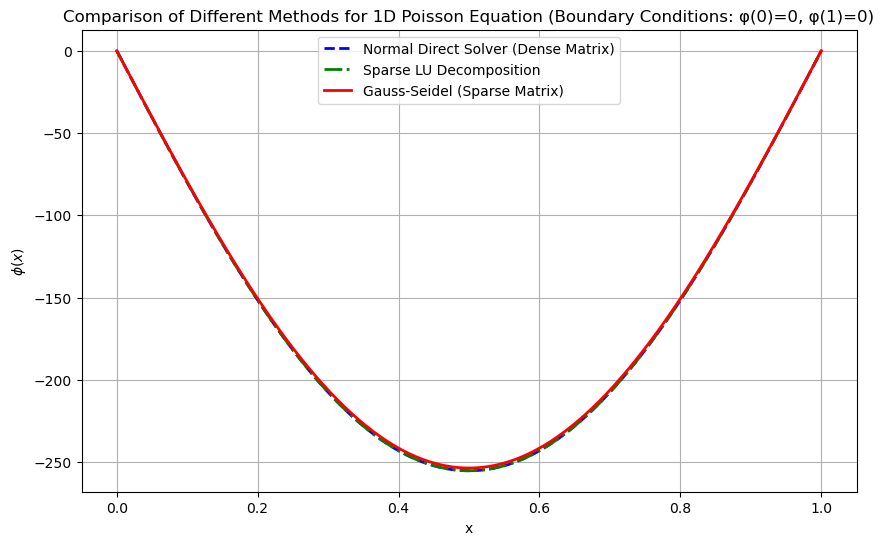

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import splu
import time  # Importing the time module

# Parameters
N = 100  # Number of grid points
L = 1.0  # Length of the domain
phi_L = 0.0  # Boundary condition at x = 0
phi_R = 0.0  # Boundary condition at x = 1
dx = L / (N - 1)  # Grid spacing

# Create the grid points
x = np.linspace(0, L, N)

# Define the source term s(x) = x * (1 - x)
s = x * (1 - x)

# Construct the right-hand side vector b
b = s.copy()
b[0] = phi_L
b[-1] = phi_R

# Method 1: Normal Direct Solver (Dense Matrix)
start_time = time.time()  # Start time for the direct method
A_dense = np.zeros((N, N))
for i in range(1, N-1):
    A_dense[i, i-1] = 1
    A_dense[i, i] = -2
    A_dense[i, i+1] = 1
A_dense[0, 0] = 1
A_dense[-1, -1] = 1
phi_normal = np.linalg.solve(A_dense, b)  # Solve the linear system
end_time = time.time()  # End time for the direct method
time_dense = end_time - start_time  # Calculate the time for the direct method

# Method 2: Sparse LU Decomposition
start_time = time.time()  # Start time for the LU Sparse method
diagonals = [
    np.ones(N-1),        # Upper diagonal
    -2 * np.ones(N),     # Main diagonal
    np.ones(N-1)         # Lower diagonal
]
offsets = [-1, 0, 1]
A_sparse = diags(diagonals, offsets, format='csc')  # Create sparse matrix directly
A_sparse[0, 0] = 1.0
A_sparse[0, 1] = 0.0
A_sparse[-1, -1] = 1.0
A_sparse[-1, -2] = 0.0
lu = splu(A_sparse)  # LU decomposition for sparse matrix
phi_lu_sparse = lu.solve(b)  # Solve the linear system
end_time = time.time()  # End time for the LU Sparse method
time_lu = end_time - start_time  # Calculate the time for the LU Sparse method

# Method 3: Gauss-Seidel with Sparse Matrix
start_time = time.time()  # Start time for the Gauss-Seidel method
phi_gs = np.zeros(N)
phi_gs[0] = phi_L
phi_gs[-1] = phi_R
max_iter = 5000  # Reduce the number of iterations
tolerance = 1e-4  # Increase tolerance for faster convergence

# Gauss-Seidel iteration
for iteration in range(max_iter):
    phi_old = phi_gs.copy()
    for i in range(1, N-1):
        a_ii = A_sparse[i, i]
        a_ij_left = A_sparse[i, i-1]
        a_ij_right = A_sparse[i, i+1]
        phi_gs[i] = (b[i] - a_ij_left * phi_gs[i-1] - a_ij_right * phi_gs[i+1]) / a_ii
    error = np.linalg.norm(phi_gs - phi_old, ord=np.inf)  # Calculate the error
    if error < tolerance:  # Check if the error is below the tolerance
        print(f"Gauss-Seidel converged after {iteration} iterations with error {error:.2e}")
        break
else:
    print("Gauss-Seidel did not converge within the maximum number of iterations")
end_time = time.time()  # End time for the Gauss-Seidel method
time_gs = end_time - start_time  # Calculate the time for the Gauss-Seidel method

# Print the times for each method
print(f"Time for Direct Solver (Dense Matrix): {time_dense:.4f} seconds")
print(f"Time for Sparse LU Decomposition: {time_lu:.4f} seconds")
print(f"Time for Gauss-Seidel (Sparse Matrix): {time_gs:.4f} seconds")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x, phi_normal, label=f'Normal Direct Solver (Dense Matrix)', color='b', linestyle='--', linewidth=2)
plt.plot(x, phi_lu_sparse, label=f'Sparse LU Decomposition', color='g', linestyle='-.', linewidth=2)
plt.plot(x, phi_gs, label=f'Gauss-Seidel (Sparse Matrix)', color='r', linestyle='-', linewidth=2)
plt.xlabel('x')
plt.ylabel(r'$\phi(x)$')
plt.title('Comparison of Different Methods for 1D Poisson Equation (Boundary Conditions: φ(0)=0, φ(1)=0)')
plt.legend()
plt.grid(True)
plt.show()
